# Survival Analysis


Lesson Goals

    Introduce survival analysis
    Introduce Kaplan-Meier estimates
    Perform survival analysis on event data
    Visualize and compare survival curves
    Perform survival analysis for cohorts from different perspectives

Introduction

Survival analysis is an important topic in analytics that rarely receives the coverage it deserves. As the name implies, it was originally developed to quantify and measure the lifespans of individuals (how likely someone was to die or survive). For example, if you wanted to know what the probability of death over time was for a certain a group of people who had contracted some illness, you would use survival analysis. However, the techniques used in survival analysis can be applied to a wide variety of situations.

In this lesson, we are going to cover the basics of survival analysis so that you can leverage this valuable set of techniques in analyses that you conduct going forward. To do this, we will need to install a new Python library called lifelines that is specifically used for conducting survival analysis.

$ pip install lifelines

We will import the components of lifelines a little later as we need them. We are also going to be using Pandas in this lesson as well as Plotly and Cufflinks, so let's go ahead and import those.

In [1]:
import pandas as pd
import plotly.plotly as py
import cufflinks as cf

cf.go_offline()

# Survival Analysis

Survival analysis can be performed on various scenarios:

    Estimating human lifespans
    Estimating mechanical failures over time
    Estimating length of customer retention
    Estimating time to recovery for illnesses

There are certain requirements for conducting a survival analysis. The first of these is that you need to have a field in your data that represents the occurrence (or lack thereof) of an event.

The second requirement is that you need to have a field that represents the passage of time in some fashion. This can be datetimes or it can be a number that increases with the passage of time, such as number of days/weeks/months/years, the number of uses, distance traveled, etc.

The third and final requirement is that you need to have at least one field to group by. Survival analysis calculates the survival rates for groups that something in common. The group by field is the thing they have in common. If you have multiple fields you can group by, you can perform the analysis for the groups represented by each field individually or you can combine them into more granular segments and examine the survival rates of those. However, you can only do this up to a point where the number of examples in a group become too few to reliably calculate their survival rates. So you need to balance the ability drill down into granular details with the need to have large enough groups to calculate meaningful and reliable survival rates.


# The Data

The data we will be working with in this lesson will be the customer churn data set from previous lessons. This data meets all three of our criteria above. It contains an event field (ChurnBinary) that indicates whether or not a customer has churned. It contains a field that represents the passage of time (tenure). And finally, it contains several categorical fields by which we can group customers so that we can explore their retention rates from different perspectives.

In [2]:
data = pd.read_csv('../data/churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low,Very Low,New,0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,Low,Moderate,Loyal,0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Low,Very Low,New,1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,Low,Moderate,Loyal,0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Moderate,Very Low,New,1.0


# Performing a Survival Analysis

Now that we have identified the data we want to use and the corresponding fields, we can begin our analysis. The objective of our analysis is going to be to get a sense of the decline in customer retention rates as tenure increases among the different groups of customers we have in our data set.

The easiest way to do this in Python is with the lifelines library. We are going to import the KaplanMeierFitter from lifelines. Kaplain-Meier curves are one of the most common statistical techniques used in survival analysis, and they will help us estimate the survival function of the different cohorts we designate (e.g. males vs. females, senior citizens vs. non-seniors, etc.).

In [3]:
from lifelines import KaplanMeierFitter

From there, we are going to define a survival function that is going to accept a data frame and then specify each of the three necessary components for conducting a survival analysis (a group field, a time field, and an event field). Within the function, we are going to define our model and then create an empty list in which we are going to store our results. From there, we loop through the each of the unique values in the group field, grab the data in the time and event fields, fit our model to the data, and append the survival function results to our results list. At the end, we concatenate the data for each unique group field value together and then return those results.

In [4]:
def survival(data, group_field, time_field, event_field):
    model = KaplanMeierFitter()
    results = []
    
    for i in data[group_field].unique():
        group = data[data[group_field]==i]
        T = group[time_field]
        E = group[event_field]
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    return survival

Once we have this function, it is relatively easy to generate survival curves for any of the cohorts in our data set. For example, if we wanted to visualize retention rates over time by gender, we could do that with just a couple lines of code.

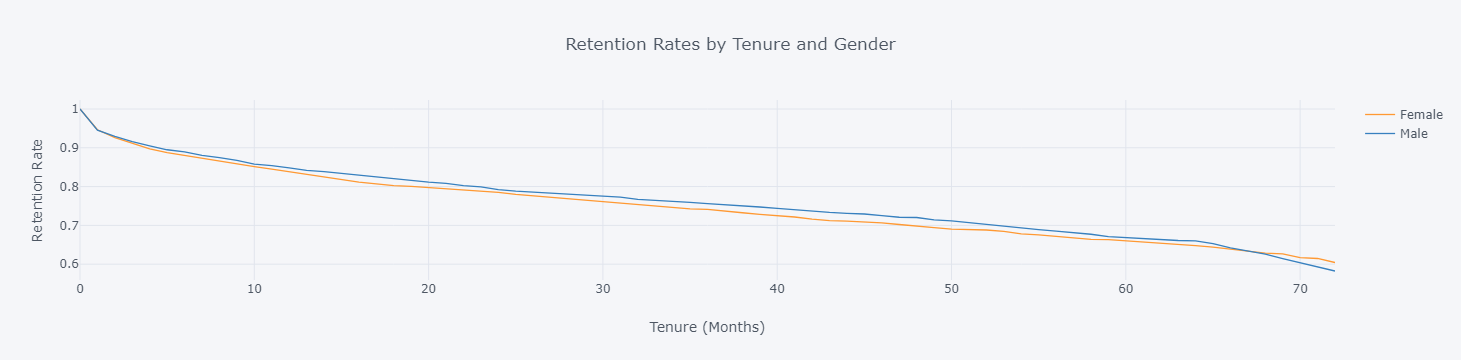

In [5]:
rates = survival(data, 'gender', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Gender')

We can see that at tenure 0, both survival curves start at 1 (100%). The female curve then declines a little faster than the male curve and then they both continue to decline gradually until they get past 60 months, at which point the male curve takes a steeper dive below the female retention rates. Both curves end at around the 60% mark, meaning that after 70 months of tenure, a customer is approximately 40% likely to churn (60% retention rate).

Using our function, we can easily swap out group fields to take a look at survival rates form different perspectives. Here are the survival curves for senior citizens and non-seniors.

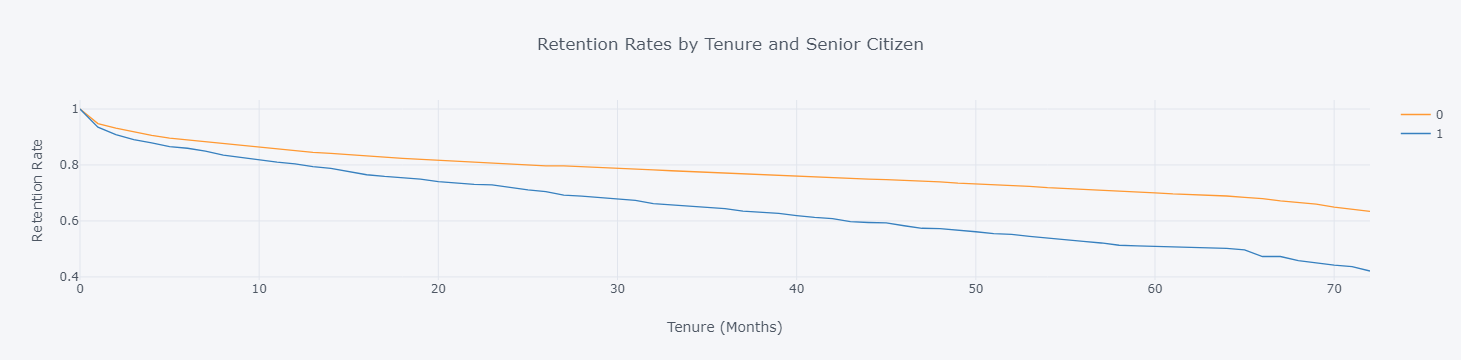

In [6]:
rates = survival(data, 'SeniorCitizen', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Senior Citizen')

From this perspective, we can see that the survival curve for senior citizens has a steeper slope than the curve for non-seniors, which causes them to end up with a much lower retention rate than non-seniors.

What if we define our cohorts around the type of Internet service the customer has as opposed to demographics?

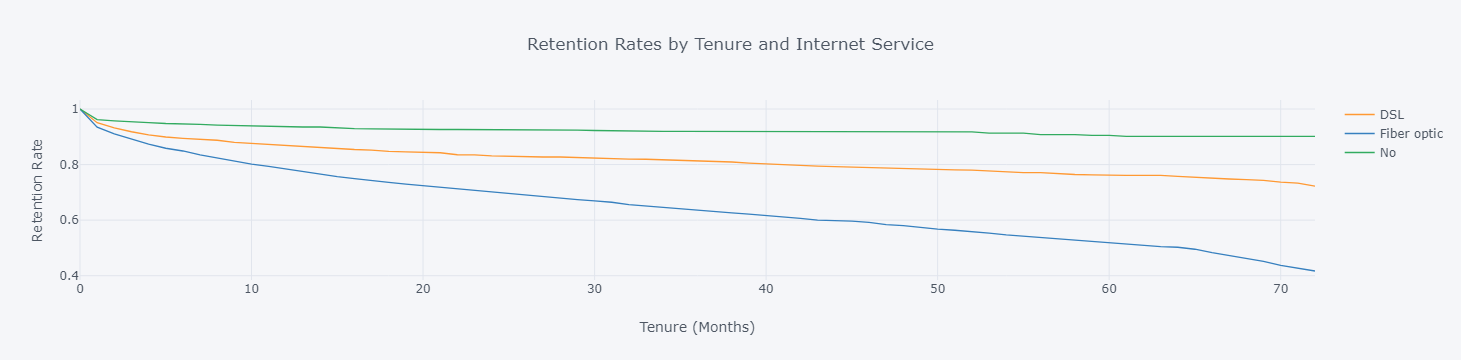

In [7]:
rates = survival(data, 'InternetService', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Internet Service')

From this perspective, we can see that customers without Internet service tend to have higher retention rates than ones who do. Among the ones that do have Internet service with the company, the ones that have DSL have much higher retention rates compared to the ones that have fiber optic, perhaps because the latter tends to be significantly more expensive.

The company also provides customers with the option of signing up for one year or two year contracts as opposed to just paying for their services month-to-month. Let's see how the survival curves look for each of those three options.

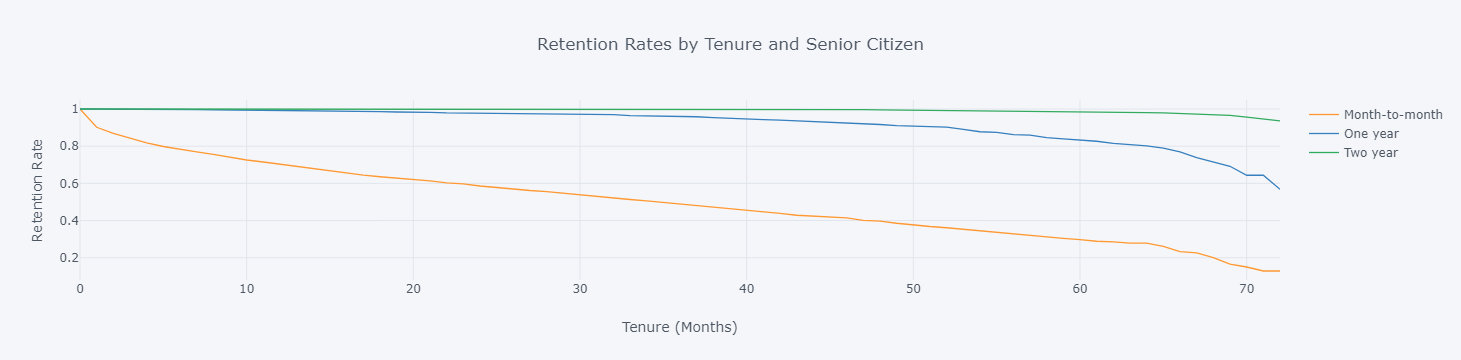

In [8]:
rates = survival(data, 'Contract', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Tenure (Months)', yTitle='Retention Rate',
            title='Retention Rates by Tenure and Senior Citizen')

As you probably expected, the customers on two year contracts have the highest retention rates, even well past the 24 month (2 year) mark. Customers on one year contracts have high retention rates until about 40 months out, and then the rate at which they churn increases. And finally, the customers who pay month-to-month start churning almost right away with a very steep decline in retention between 0 and 10 months and then leveling off slightly but still pretty steep.



# Usefulness of Survival Analysis

As we saw above, survival analysis is useful for deriving insights about what factors matter most when you have event data over time. In our case, we were able to observe the survival curves estimating what percentage of customers the company would retain and what percentage are likely to churn over time from varying perspectives.

This is useful to companies, as it allows them estimate when a customer is most likely to cancel their service. The company could then determine the appropriate time to intervene and offer the customer either a discounted upgrade or a lower price on the service they currently have (perhaps tied to a one or two year contract) to prevent them from leaving and thus increasing their retention rates.
